In [ ]:
!pip install kaggle


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install transformers tensorflow



In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d sripaadsrinivasan/fish-species-image-data

Dataset URL: https://www.kaggle.com/datasets/sripaadsrinivasan/fish-species-image-data
License(s): CC-BY-SA-3.0
100% 1.30G/1.31G [00:11<00:00, 89.3MB/s]
100% 1.31G/1.31G [00:11<00:00, 122MB/s] 


In [ ]:
os.mkdir('/content/fish_dataset')

In [ ]:
import zipfile
import os

with zipfile.ZipFile("/content/fish-species-image-data.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/fish_dataset")

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D,GlobalAveragePooling2D, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from transformers import ViTImageProcessor, TFAutoModelForImageClassification
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
directory_path = '/content/fish_dataset/Fish_Data/images/cropped'
# Count images per class
cnt = {}
for filename in os.listdir(directory_path):
    if os.path.isfile(os.path.join(directory_path, filename)):
        name = filename.split('_')[0]
        cnt[name] = cnt.get(name, 0) + 1
# Sort and get the top 10 classes
sorted_dict = dict(sorted(cnt.items(), key=lambda item: item[1], reverse=True))
top10dict = dict(list(sorted_dict.items())[:10])
# Loading images and labels
X = []
y = []
for filename in os.listdir(directory_path):
    if os.path.isfile(os.path.join(directory_path, filename)) and filename.split('_')[0] in top10dict:
        img = cv2.imread(os.path.join(directory_path, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X.append(img)
        y.append(filename.split('_')[0])
# Encoding labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Spliting data
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# Resizing images
X_train = [cv2.resize(img, (224, 224)) for img in X_train]
X_val = [cv2.resize(img, (224, 224)) for img in X_val]
X_test = [cv2.resize(img, (224, 224)) for img in X_test]
X_train = np.array(X_train) / 255.0
X_val = np.array(X_val) / 255.0
X_test = np.array(X_test) / 255.0

In [ ]:
# Define VGG16 model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_x = vgg_base.output
vgg_x = GlobalAveragePooling2D()(vgg_x)
vgg_x = Dense(256, activation='relu')(vgg_x)
vgg_x = Dropout(0.3)(vgg_x)
# Define ViT model
vit_model_name = 'google/vit-base-patch16-224'
vit_processor = ViTImageProcessor.from_pretrained(vit_model_name, do_rescale=False)
vit_model = TFAutoModelForImageClassification.from_pretrained(vit_model_name)
def vit_preprocess(imgs):
    return np.array([vit_processor(images=img, return_tensors='tf')['pixel_values'][0].numpy() for img in imgs])
# Preprocess data for ViT
X_train_vit = vit_preprocess(X_train)
X_val_vit = vit_preprocess(X_val)
X_test_vit = vit_preprocess(X_test)
# Ensure input shapes are correct for ViT
vit_input = Input(shape=(3, 224, 224), name='vit_input', dtype=tf.float32)
vit_features = vit_model.vit(vit_input)[0]
vit_x = GlobalAveragePooling1D()(vit_features)
vit_x = Dense(256, activation='relu')(vit_x)
vit_x = Dropout(0.3)(vit_x)
# Combine VGG16 and ViT models
combined_x = Concatenate()([vgg_x, vit_x])
predictions = Dense(len(top10dict), activation='softmax')(combined_x)
# Define the final model
combined_model = Model(inputs=[vgg_base.input, vit_input], outputs=predictions)
# Compile the model
combined_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [ ]:
epochs = 20
batch_size = 32
# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Fit the data generator on the training data
datagen.fit(X_train)
# Create the data generator for training
train_generator = datagen.flow([X_train, X_train_vit], y_train, batch_size=batch_size)
# Training the model
history = combined_model.fit(train_generator, epochs=epochs,
                             validation_data=([X_val, X_val_vit], y_val))

Epoch 1/20
33/33 [==============================] - 102s 2s/step - loss: 1.9466 - accuracy: 0.3423 - val_loss: 1.5112 - val_accuracy: 0.5159
Epoch 2/20
33/33 [==============================] - 35s 1s/step - loss: 1.3760 - accuracy: 0.5683 - val_loss: 1.1674 - val_accuracy: 0.6369
Epoch 3/20
33/33 [==============================] - 35s 1s/step - loss: 1.0481 - accuracy: 0.6567 - val_loss: 0.9290 - val_accuracy: 0.7032
Epoch 4/20
33/33 [==============================] - 39s 1s/step - loss: 0.9650 - accuracy: 0.6990 - val_loss: 0.8708 - val_accuracy: 0.6801
Epoch 5/20
33/33 [==============================] - 35s 1s/step - loss: 0.7877 - accuracy: 0.7385 - val_loss: 0.8266 - val_accuracy: 0.7349
Epoch 6/20
33/33 [==============================] - 36s 1s/step - loss: 0.7070 - accuracy: 0.7760 - val_loss: 0.7249 - val_accuracy: 0.7579
Epoch 7/20
33/33 [==============================] - 39s 1s/step - loss: 0.5946 - accuracy: 0.8115 - val_loss: 0.7290 - val_accuracy: 0.7493
Epoch 8/20
33/33 [=

In [ ]:
test_loss, test_accuracy = combined_model.evaluate([X_test, X_test_vit], y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

11/11 [==============================] - 6s 569ms/step - loss: 0.3041 - accuracy: 0.9135
Test Loss: 0.3041
Test Accuracy: 0.9135


11/11 [==============================] - 15s 531ms/step


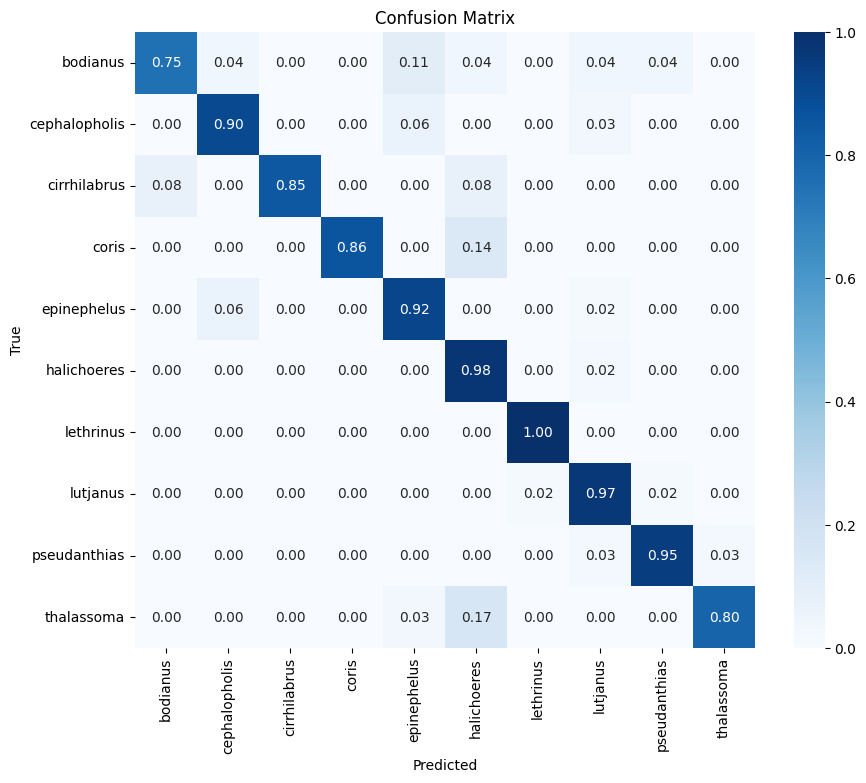

In [ ]:
# Plot Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Generate predictions
y_pred = combined_model.predict([X_test, X_test_vit])
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Generating predictions
y_pred = combined_model.predict([X_test, X_test_vit])
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculating precision, recall, and F1-score
report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print(report)

11/11 [==============================] - 6s 539ms/step
               precision    recall  f1-score   support

     bodianus       0.95      0.75      0.84        28
cephalopholis       0.85      0.90      0.88        31
 cirrhilabrus       1.00      0.85      0.92        13
        coris       1.00      0.86      0.92        14
  epinephelus       0.91      0.92      0.91        63
  halichoeres       0.82      0.98      0.89        41
    lethrinus       0.96      1.00      0.98        26
     lutjanus       0.92      0.97      0.95        63
 pseudanthias       0.95      0.95      0.95        38
   thalassoma       0.96      0.80      0.87        30

     accuracy                           0.91       347
    macro avg       0.93      0.90      0.91       347
 weighted avg       0.92      0.91      0.91       347



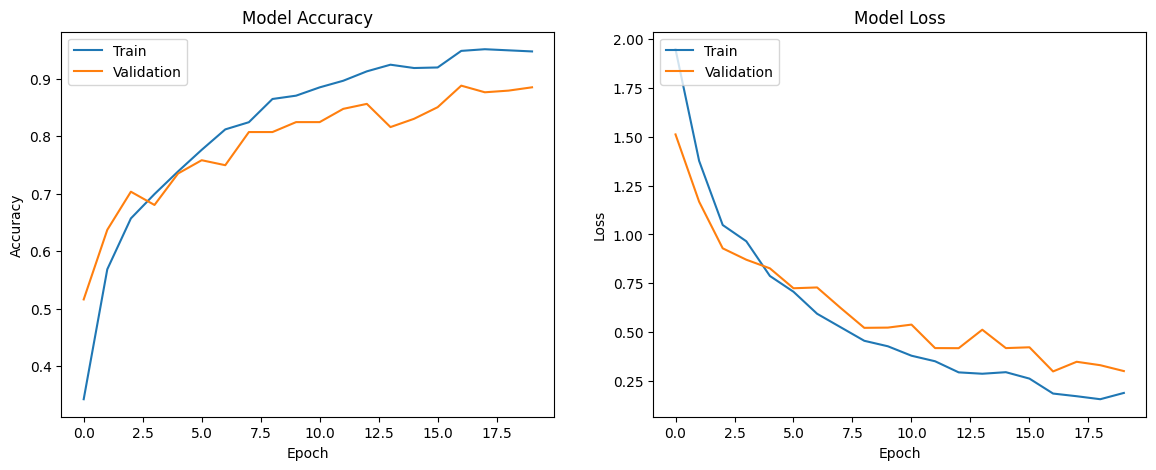

In [ ]:
import matplotlib.pyplot as plt
# Ploting training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Ploting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

11/11 [==============================] - 6s 507ms/step


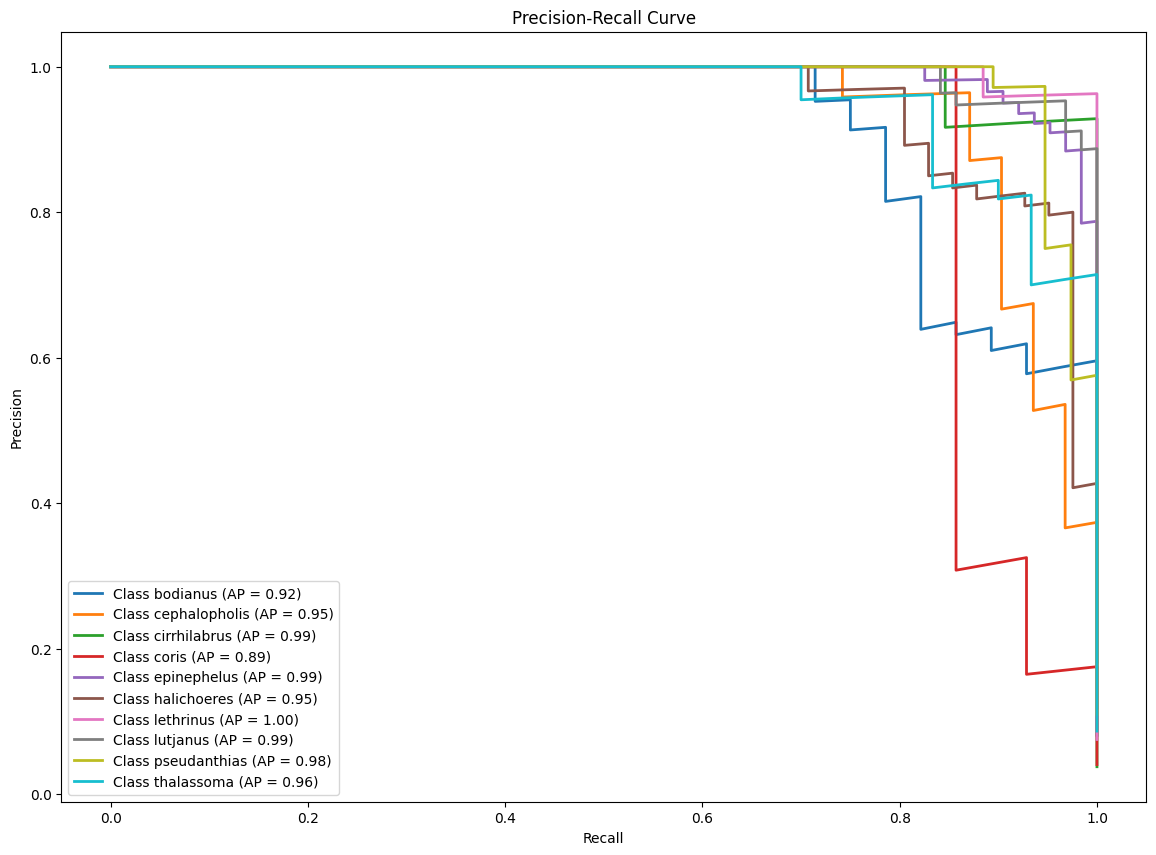

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
# Generating predictions
y_pred_probs = combined_model.predict([X_test, X_test_vit])

# Calculating precision-recall curve and average precision score
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(label_encoder.classes_)):
    precision[i], recall[i], _ = precision_recall_curve(y_test == i, y_pred_probs[:, i])
    average_precision[i] = average_precision_score(y_test == i, y_pred_probs[:, i])

# Ploting precision-recall curve for each class
plt.figure(figsize=(14, 10))
for i in range(len(label_encoder.classes_)):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {label_encoder.classes_[i]} (AP = {average_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()


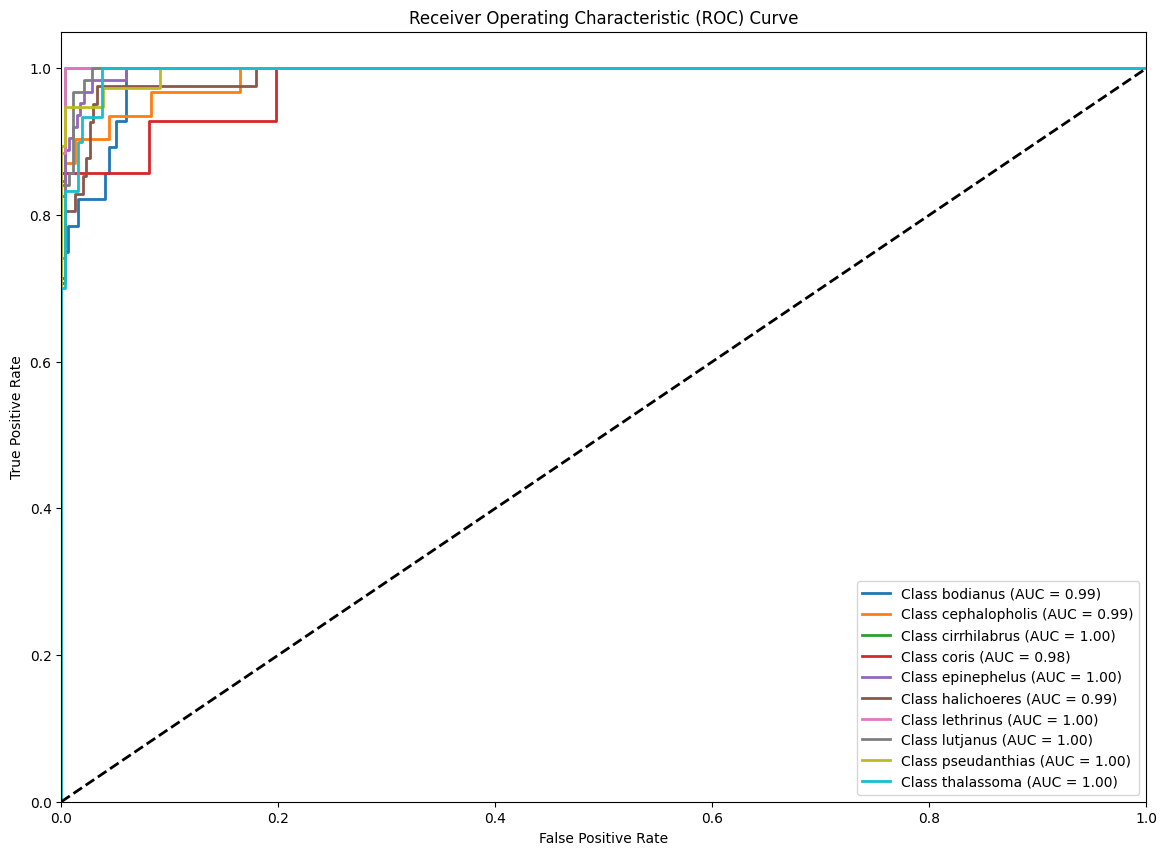

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
# Binarizing the output
y_test_binarized = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
n_classes = y_test_binarized.shape[1]

# Computing ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Ploting ROC curve for each class
plt.figure(figsize=(14, 10))
colors = plt.colormaps['tab10'](np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()
